# Combining accuracy per time step for operators

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [ ]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

## Processing functions

In [ ]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [ ]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))
    
    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, n_steps_in:int, n_steps_out:int):
    fig = plt.figure(figsize=(10, 6))
    pred = plt.plot(np.array(pred), color=mode_colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=mode_colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{operator}\nTraining features: {comb}\nLook-back: {n_steps_in}, Looh-ahead: {n_steps_out}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()
    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    # train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        # train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    # print(acc)
    # print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    # bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    # add_value_labels(bars2)

    plt.show()
    return fig

def box_lookback(results:dict, n_steps_out:int, operator:str):
    sep1 = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'] 
    comb1 = ['RSRP, SSS_RSRP', 'SINR, SSS_SINR', 'RSRQ, SSS_RSRQ']
    cat2 = ['RSRP, SINR', 'RSRP, RSRQ', 'SINR, RSRQ', 'SSS_RSRP, SSS_SINR', 'SSS_RSRP, SSS_RSRQ', 'SSS_SINR, SSS_RSRQ']
    sep3 = ['RSRP, SINR, RSRQ', 'SSS_RSRP, SSS_SINR, SSS_RSRQ']
    comb3 = ['All']

    names = ['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'All']

    xncombs = list(results.keys())
    
    accs = [[[] for _ in range(len(names))] for _ in range(len(xncombs))]

    for i in range(len(xncombs)):
        for key in results[xncombs[i]]:
            if key in sep1:
                for j in range(n_steps_out):
                    accs[i][0].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb1:
                for j in range(n_steps_out):
                    accs[i][1].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in cat2:
                for j in range(n_steps_out):
                    accs[i][2].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in sep3:
                for j in range(n_steps_out):
                    accs[i][3].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb3:
                for j in range(n_steps_out):
                    accs[i][4].append(results[xncombs[i]][key]['Accuracy_list'][j])

    flattened_data = []
    for group_index, group in enumerate(accs):
        for category_index, accuracies in enumerate(group):
            for accuracy in accuracies:
                flattened_data.append({
                    'Look-back': xncombs[group_index],
                    'Category': names[category_index],
                    'Accuracy': accuracy
                })

    df = pd.DataFrame(flattened_data)

    fig = plt.figure(figsize=(10, 6))
    sns.violinplot(x='Look-back', y='Accuracy', hue='Category', data=df, palette=sns.color_palette('Greens'), inner='quart', gap=0.1, zorder=2)
    plt.grid(zorder=0)

    means = df.groupby(['Look-back', 'Category'])['Accuracy'].mean().reset_index()
    i = 0
    for _, row in means.iterrows():
        if row['Category'] == 'All':
            plt.annotate(f'{row["Accuracy"]:.2f}', 
                        xy=(i + 0.32, row['Accuracy']), 
                        xytext=(0, 5),
                        textcoords='offset points', 
                        ha='center',
                        color='black', 
                        fontsize=9)
            i += 1
        
    plt.title(f'{operator}\nAccuracies by Look-Back and Feature Combination\nLook-ahead is {n_steps_out} time steps')
    plt.legend(ncols=3)
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results_op1:dict, results_op2:dict, n_steps_out:str, n_steps_in:str, whiskers=[0, 100]):
    op1_accuracy = [[] for _ in range(n_steps_out)]
    op2_accuracy = [[] for _ in range(n_steps_out)]

    for key in results_op1:
        for i in range(n_steps_out):
            op1_accuracy[i].append(results_op1[key]['Accuracy_list'][i])
    for key in results_op2:
        for i in range(n_steps_out):
            op2_accuracy[i].append(results_op2[key]['Accuracy_list'][i])
    
    df_combined = pd.DataFrame(columns=['Accuracy', 'Timestep', 'Operator'])
    for i in range(n_steps_out):
        for acc in op1_accuracy[i]:
            new_row = {'Accuracy': acc, 'Timestep': i, 'Operator': 'Operator 1'}
            df_combined = pd.concat([df_combined, pd.DataFrame([new_row])], ignore_index=True)
        for acc in op2_accuracy[i]:
            new_row = {'Accuracy': acc, 'Timestep': i, 'Operator': 'Operator 2'}
            df_combined = pd.concat([df_combined, pd.DataFrame([new_row])], ignore_index=True)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_combined, x='Timestep', y='Accuracy', hue='Operator', palette=[sns.color_palette('Greens')[1], sns.color_palette('Greens')[3]], whis=whiskers, zorder=2)
    plt.title(f'Accuracy per time step with look-back of {n_steps_in}')
    plt.ylabel('Accuracy')
    plt.xlabel('Steps ahead')
    plt.xticks(range(n_steps_out), labels[0:n_steps_out])
    plt.grid(zorder=0)
    plt.tight_layout()
    plt.show()
    
    return fig

In [ ]:
# Parameters
tf.random.set_seed(4567)
op1_dataset = 'datasets/Op1_merged.csv'
op2_dataset = 'datasets/Op2_merged.csv'

op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
           'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
           'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

op1_test = read_dataset(op1_dataset, campaigns=[op1_overlap[0]])
op1_train = read_dataset(op1_dataset, campaigns=op1_overlap[1:4])

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[4]])
op1_train = pd.concat([route_to_add[5400::], op1_train])
op1_train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[5]])
op1_train = pd.concat([route_to_add[0:1180], op1_train])
op1_train.reset_index(drop=True, inplace=True)

op1_campaigns = op1_train['campaign'].unique().tolist()
op1_test_campaigns = op1_test['campaign'].unique().tolist()

op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

op2_test = read_dataset(op2_dataset, campaigns=[op2_overlap[0]])
op2_train = read_dataset(op2_dataset, campaigns=op2_overlap[1:3])

# only a part of this route overlaps with the others
route_to_add = read_dataset(op2_dataset, campaigns=[op2_overlap[3]])
op2_test = pd.concat([route_to_add[5350::], op2_test])
op2_test.reset_index(drop=True, inplace=True)

op2_campaigns = op2_train['campaign'].unique().tolist()
op2_test_campaigns = op2_test['campaign'].unique().tolist()

In [ ]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

op1_units = [10, 10, 10]
op2_units = [10, 10, 5]

## 1 look-ahead

In [ ]:
n_steps_ins, n_steps_out = [1, 2, 5], 1

op1_step1_results = {}
op2_step1_results = {}

for n_steps_in in n_steps_ins:
    op1_temp_results = {}
    op2_temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            op1_temp_results[used_features] = long_short_term_memory(train=op1_train[features], test=op2_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=op1_units)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            op2_temp_results[used_features] = long_short_term_memory(train=op2_train[features], test=op1_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=op2_units)
    op1_step1_results[f'x:{n_steps_in}'] = op1_temp_results
    op2_step1_results[f'x:{n_steps_in}'] = op2_temp_results

## 3 look-ahead

In [ ]:
n_steps_ins, n_steps_out = [1, 3, 5], 3

op1_step3_results = {}
op2_step3_results = {}

for n_steps_in in n_steps_ins:
    op1_temp_results = {}
    op2_temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            op1_temp_results[used_features] = long_short_term_memory(train=op1_train[features], test=op1_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=op1_units)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            op2_temp_results[used_features] = long_short_term_memory(train=op2_train[features], test=op2_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=op2_units)
    op1_step3_results[f'x:{n_steps_in}'] = op1_temp_results
    op2_step3_results[f'x:{n_steps_in}'] = op2_temp_results

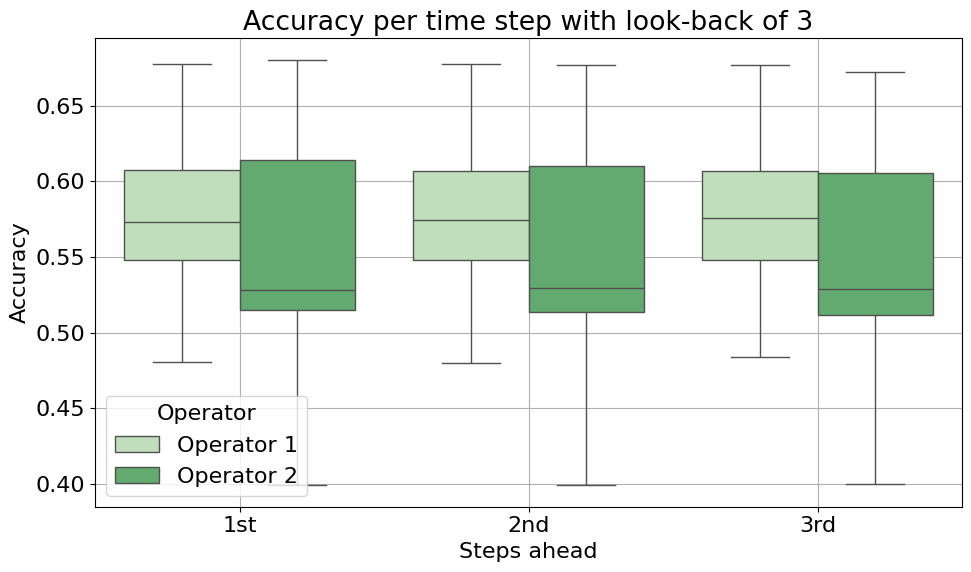

In [52]:
fig = boxplot_accuracies(results_op1=op1_step3_results['x:3'], results_op2=op2_step3_results['x:3'], n_steps_out=3, n_steps_in=3)
fig.savefig(r'../latex/plots/lstm_mode/box_timestep_acc_x3n3.pdf')

## 5 look-ahead

In [49]:
n_steps_ins, n_steps_out = [2, 5, 8], 5

op1_step5_results = {}
op2_step5_results = {}

for n_steps_in in n_steps_ins:
    op1_temp_results = {}
    op2_temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            op1_temp_results[used_features] = long_short_term_memory(train=op1_train[features], test=op1_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=op1_units)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            op2_temp_results[used_features] = long_short_term_memory(train=op2_train[features], test=op2_test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=op2_units)
    op1_step5_results[f'x:{n_steps_in}'] = op1_temp_results
    op2_step5_results[f'x:{n_steps_in}'] = op2_temp_results

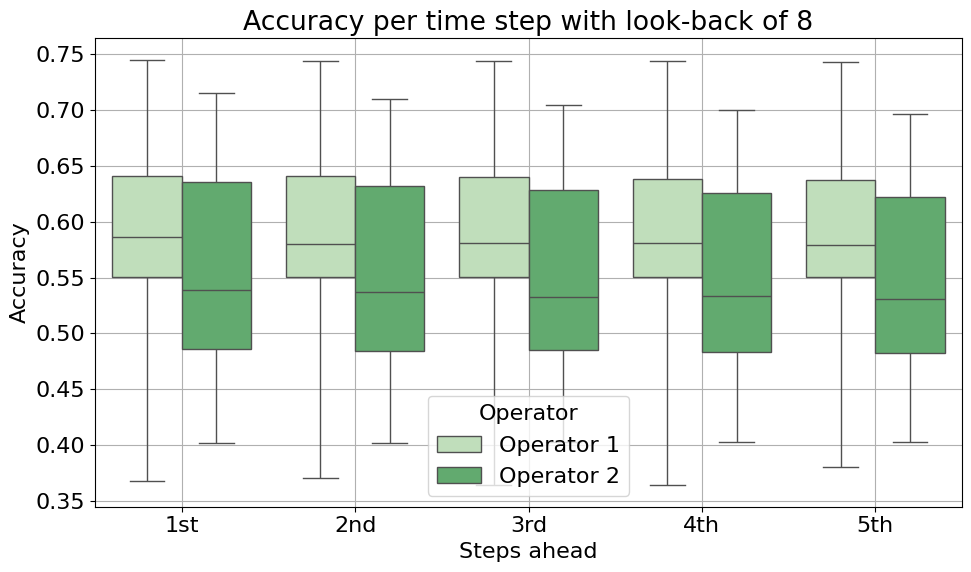

In [51]:
fig = boxplot_accuracies(results_op1=op1_step5_results['x:8'], results_op2=op2_step5_results['x:8'], n_steps_out=5, n_steps_in=8)
fig.savefig(r'../latex/plots/lstm_mode/box_timestep_acc_x8n5.pdf')